#### This tutorial aims to give a detailed instruction about TCPFlow


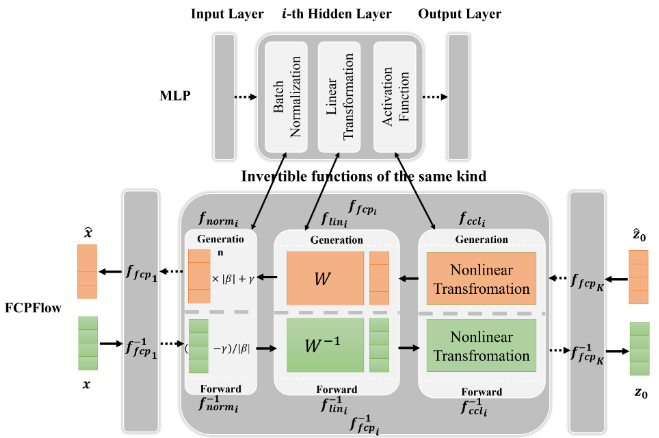

In [1]:
# import torch
import torch.nn as nn
import torch
import torch.nn.functional as F

torch.set_default_dtype(torch.float64) # set default data type

### Inveritable normalization layer

The functionality of the invertible normalization layer $f_{norm_i}$ is demonstrated. This operation is mathematically expressed as 
$$
\begin{align}
\text{Forward } f^{-1}_{norm} \quad & \mathbf{z} = \frac{\mathbf{x} - \gamma}{\sqrt{\beta^2 + \epsilon}} \\
\text{Generation }f_{norm} \quad & \mathbf{x} = \mathbf{z} \cdot \sqrt{\beta^2 + \epsilon} +\gamma
\end{align}
$$
where $\gamma$ and $\beta$ are parameters that have the same shape as $\mathbf{x}$ and $\mathbf{z}$, $\epsilon$ is a small constant ensuring numerical stability. 

To compute the log-likelihood in for FCPFlow, the log-determinant of the invertible normalization layer $f_{norm}$ is required, this is expressed as 

$$
\begin{equation}
   \log|\det\left(\frac{\partial f^{-1}_{norm}(\mathbf{x})}{\partial \mathbf{x}^\mathrm{T}}\right)| = -\log(|\prod^{T}_{i=1}(|\beta_i| + \epsilon)|)
\end{equation}
$$

where $T$ is the length of vector $\beta$, $\beta_i$ denoting the $i$-th element of vector $\beta$, for $i\in {1, 2,...,T}$. 


In [2]:
class InvertibleNorm(nn.Module):
    def __init__(self, num_channels):
        super(InvertibleNorm, self).__init__()
        self.num_channels = num_channels
        # Initialize running mean and standard deviation
        self.register_buffer('running_mean', torch.zeros(1, num_channels, 1)) # register_buffer is a function that registers a buffer as part of the module's state
        self.register_buffer('running_std', torch.ones(1, num_channels, 1)) # register_buffer is a function that registers a buffer as part of the module's state
        self.initialized = False
        self.momentum = 0.1

    def forward(self, input):
        if self.training:
            # Calculate mean and std dev for the current batch
            mean = torch.mean(input, dim=[0, 2], keepdim=True) # calculate mean
            std = torch.std(input, dim=[0, 2], keepdim=True) + 1e-10 # calculate standard deviation

            # Normalize input using calculated mean and std dev
            normalized_input = (input - mean) / std # normalize input

            # Update running statistics
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean # update running mean
            self.running_std = (1 - self.momentum) * self.running_std + self.momentum * std # update running std dev
        else:
            # Normalize input using running statistics during evaluation
            normalized_input = (input - self.running_mean) / self.running_std # normalize input

        # log-determinant of the Jacobian
        self.scale = 1 / (std + 1e-10) # calculate scale
        log_det = (
            torch.sum(torch.log(torch.abs(self.scale.squeeze() + 1e-10))) # calculate log determinant
        )
        return normalized_input, log_det

    def inverse(self, output):
        # Use running_mean and running_std for the inverse normalization
        return (output * self.running_std) + self.running_mean
    

### Inveritable linear layer

The functionality of the invertible normalization layer $f_{lin_i}$ is also demonstrated. This operation is mathematically expressed as 
$$
\begin{align}
\text{Forward } f^{-1}_{lin} \quad & \mathbf{z} = \mathbf{W^{-1}x} \\
\text{Generation }f_{lin} \quad & \mathbf{x} = \mathbf{W}\mathbf{z},
\end{align}
$$
where $\mathbf{W}$ is a invertible matrix. The invertible linear layer is an important component for enhancing the modeling capacity of the FCPFlow model. The underlying rationale for this operation lies in $\mathbf{W}$ being trained to understand the correlations among individual time steps of the RLP data. By working together with the nonlinear transformations provided by $f_{ccl}$, FCPFlow models can accurately describe the complex, high-dimensional correlations inherent in RLP data.

The log-determinants of the invertible linear layer $f_{lin}$ is expressed as
$$
\begin{equation}
    \log |\det(\frac{\mathrm{d}f^{-1}_{lin}(\mathbf{x})}{\mathrm{d}\mathbf{x^T}})|=\log |\det(\mathbf{W^{-1}})|.

\end{equation}
$$

In [3]:
class InvertibleWConv(nn.Module):
    def __init__(self, num_channels):
        super(InvertibleWConv, self).__init__()
        self.num_channels = num_channels # Length of the input vector

        # Initialize weights with a random rotation matrix
        w_init = torch.qr(torch.randn(num_channels, num_channels))[0] # QR decomposition returns a rotation matrix
        self.w = nn.Parameter(w_init) # Learnable weights

    def forward(self, input):
        out = F.conv1d(input, self.w.view(self.num_channels, self.num_channels, 1)) # Apply the weights
        log_det = torch.slogdet(self.w)[1] # Log determinant of the Jacobian, the w is $W^{-1}$ in the paper
        return out, log_det

    def inverse(self, y):
        # Compute the inverse of the weights
        w_inv = torch.inverse(self.w) # The inverse of the weights
        return F.conv1d(y, w_inv.view(self.num_channels, self.num_channels, 1))

### Combining Coupling Layer
 The forward process of combining coupling layers $f^{-1}_{ccl}$ can be expressed as 
 $$
\begin{align}
   & \mathbf{x_{1}, x_{2}}  = Split(\mathbf{x})  \\ 
   & \mathbf{(x_1, c)} = Combine(\mathbf{x_1, c}) \\
   & \mathbf{z_1} = exp(s_1(\mathbf{x_1,c})) \odot \mathbf{x_2} + t_1(\mathbf{x_1,c}) \\
   & \mathbf{(z_1, c)} = Combine(\mathbf{z_1, c}) \\
   & \mathbf{z_2} = exp(s_2(\mathbf{z_1, c})) \odot \mathbf{x_1} + t_2(\mathbf{z_1, c}) \\
   & \mathbf{z} = Combine(\mathbf{z_1, z_2})
\end{align}
$$
where $\mathbf{x}$ corresponds to the RLPs data, the operation $Split(\cdot)$ partitions the input vector$\mathbf{x}$ into two sub-vectors, $\mathbf{x_1}$ and $\mathbf{x_2}$, corresponding to the even and odd elements of $\mathbf{x}$, $s$ and $t$ are NNs, $Combine(\cdot)$ operation refers to the method used to merge two vectors into a single vector, the symbol $\odot$ indicates element-wise multiplication. The generation process of combining coupling layers $f_{ccl}$ can be expressed as
$$
\begin{align}
   & \mathbf{z_{1}, z_{2}}  = Split(\mathbf{z}) \\
   & \mathbf{(z_1, c)} = Combine(\mathbf{z_1, c}) \\
   & \mathbf{x_1} = (\mathbf{z_2} - t_2(\mathbf{z_1,c}))/ exp(s_2(\mathbf{z_1,c})) \\
   & \mathbf{(x_1, c)} = Combine(\mathbf{x_1, c}) \\
   & \mathbf{x_2} = (\mathbf{z_1} - t_1(\mathbf{x_1,c}))/ exp(s_1(\mathbf{x_1,c})) \\
   & \mathbf{x} = Combine(\mathbf{x_1, x_2}) 
\end{align}
$$
As previously discussed, to obtain the optimal set of parameters of NNs $s$ and $t$, Equation (\ref{eq6}) can be used. To do this, we need the log-determinant of $\frac{\partial f^{-1}_{ccl}(\mathbf{x;c})}{\partial \mathbf{x}^\mathrm{T}}$. The log-determinant of the $\frac{\partial f^{-1}_{ccl}(\mathbf{x;c})}{\partial \mathbf{x}^\mathrm{T}}$ can be expressed as
$$
\begin{align}
    \log|\det\left(\frac{\partial f^{-1}_{ccl}(\mathbf{x;c})}{\partial \mathbf{x}^\mathrm{T}}\right)| &= \log |\det\begin{pmatrix}
    \mathbb{I} &  \mathbf{0} \\
    * & \exp(s_2(\mathbf{z_1};c))
    \end{pmatrix}| \nonumber \\
    &\quad + \log |\det\begin{pmatrix}
    \mathbb{I} &  \mathbf{0} \\
    * & \exp(s_1(\mathbf{x_1};c))
    \end{pmatrix}|
   
\end{align}
$$
where $\mathbb{I}$ is the identity matrix, the symbol $*$ denotes the elements in the lower-left quadrant. These elements are represented by $*$ because they do not influence the value of the log-determinant being considered. 


In [4]:

class ConditionalAffineCouplingLayer(nn.Module):
    def __init__(self, net_type, sfactor, input_dim, hidden_dim, condition_dim, output_dim):
        super(ConditionalAffineCouplingLayer, self).__init__()
        self.input_dim = input_dim # Length of the input vector
        self.hidden_dim = hidden_dim # Length of the hidden vector
        self.output_dim = output_dim # Length of the output vector
        self.condition_dim = condition_dim # Length of the condition vector
        self.net_type = net_type # Type of the network， only 'fullconv' is supported
        self.sfactor = sfactor # Scaling factor

        # Conditional scale and translation networks
        self.scale_net1 = self._create_conditional_network1() # s1 NNs in the paper
        self.translate_net1 = self._create_conditional_network2() # t1 NNs in the paper
        self.scale_net2 = self._create_conditional_network1() # s2 NNs in the paper
        self.translate_net2 = self._create_conditional_network2() # t2 NNs in the paper

    def _create_conditional_network1(self):
        # Network that accepts both input and condition
        in_channel = int(self.input_dim/2)+self.condition_dim
        hidden_channel = self.hidden_dim
        out_channel = int(self.output_dim/2)
       
        if self.net_type == 'fullconv':
            return Simple1DfullConvNet(in_channel, hidden_channel, out_channel, True)
        
    def _create_conditional_network2(self):
        # Network that accepts both input and condition
        in_channel = int(self.input_dim/2)+self.condition_dim
        hidden_channel = self.hidden_dim
        out_channel = int(self.output_dim/2)
        if self.net_type == 'fullconv':
            return Simple1DfullConvNet(in_channel, hidden_channel, out_channel, True)
    
    def _positional_encoding(self, x): # Positional encoding
        length = x.shape[1]
        d_model = 1
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        
        # Compute the positional encoding values
        pe = torch.zeros(length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.reshape(1, length)
        
    def forward(self, x, condition):
        # First Affine 
        x = x + self._positional_encoding(x) # Add positional encoding
        x11 = x[:,0::2] # split the input into two part, even
        x12 = x[:,1::2] # split the input into two part, odd
        s1 = self.scale_net1(torch.cat([x11, condition], dim=1)) # s1
        s1 = torch.atan(s1/self.sfactor)*2*self.sfactor/torch.pi # smooth trick
        t1 = self.translate_net1(torch.cat([x11, condition], dim=1)) # t1
        x12_trans = x12 # redundant code :), the heritage of the previous version
        
        x12_exp = x12_trans*torch.exp(s1)+t1 # x2 = x1*exp(s1)+t1
        log_det_exp_1 = torch.sum(s1, dim=[1]) # log_det_exp_1 = sum(s1)
        x2 = torch.empty_like(x) # prepare for the output
        x2[:,0::2] = x11 
        x2[:,1::2] = x12_exp
        log_det_1 = log_det_exp_1  # redundant code :), the heritage of the previous version
        

        # Second Affine 
        x21 = x2[:,0::2] # split the input into two part, even
        x22 = x2[:,1::2] # split the input into two part, odd
        s2 = self.scale_net2(torch.cat([x22, condition], dim=1)) # s2
        s2 = torch.atan(s2/self.sfactor)*2*self.sfactor/torch.pi # smooth trick
        t2 = self.translate_net2(torch.cat([x22, condition], dim=1)) # t2
        x21_trans = x21  # redundant code :), the heritage of the previous version

        x21_exp = x21_trans*torch.exp(s2)+t2 # x1 = x2*exp(s2)+t2
        log_det_exp_2 = torch.sum(s2, dim=[1]) # log_det_exp_2 = sum(s2)
        y = torch.empty_like(x2) # prepare for the output 
        y[:,0::2] = x21_exp 
        y[:,1::2] = x22
        log_det_2 = log_det_exp_2 # redundant code :), the heritage of the previous version
    
        # Compute log-determinant
        log_det = log_det_1 + log_det_2 # log_det = log_det_1 + log_det_2

        return y, log_det.mean() 

    def inverse(self, y, condition):
        x21_exp = y[:,0::2]
        x22 = y[:,1::2]
        s2 = self.scale_net2(torch.cat([x22, condition], dim=1))
        s2 = torch.atan(s2/self.sfactor)*2*self.sfactor/torch.pi
        t2 = self.translate_net2(torch.cat([x22, condition], dim=1))
        x21_trans = (x21_exp-t2)/torch.exp(s2)
        x21 = x21_trans 
        x2 = torch.empty_like(y)
        x2[:,0::2] = x21
        x2[:,1::2] = x22
                
        x11 = x2[:,0::2]
        x12_exp = x2[:,1::2]
        s1 = self.scale_net1(torch.cat([x11, condition], dim=1)) 
        s1 = torch.atan(s1/self.sfactor)*2*self.sfactor/torch.pi
        t1 = self.translate_net1(torch.cat([x11, condition], dim=1))
        x12_trans = (x12_exp-t1)/torch.exp(s1)
        x12 = x12_trans # + sigma1
    
        x = torch.empty_like(y)
        x[:,0::2] = x11
        x[:,1::2] = x12
        
        x = x - self._positional_encoding(x)
        return x

# Define the simple 1D full convolutional network
class Simple1DfullConvNet(nn.Module):
    def __init__(self, in_c, h_c, out_c, linear = False):
        super().__init__()
        self.in_c = in_c
        self.h_c = h_c
        self.out_c = out_c
        self.linear = linear
        self.bias = True
        self.model = nn.Sequential( 
            nn.Linear(in_features=self.in_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=self.h_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=self.h_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=self.h_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
        )
        
        self.linear_model = nn.Linear(self.h_c, self.out_c)
        # self.leakrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        if not self.linear:
                # x = x.reshape(x.shape[0], self.in_c, 1)
                x = self.model(x)
                x = x.view(x.shape[0], -1)
                x = self.linear_model(x)
                x = self.leakrelu(x)
                return x
        else:
                # x = x.reshape(x.shape[0], self.in_c, 1)
                x = self.model(x)
                x = x.view(x.shape[0], -1)
                x = self.linear_model(x)
                return x

### FCPflow layer

In the proposed FCPFlow architecture, each transformation, denoted as $f_{fcl_i}$, is composed of three distinct components: an invertible normalization layer $f_{norm_i}$, an invertible linear layer $f_{lin_i}$, and a combining coupling layer $f_{ccl_i}$. Therefore, the operation of each transformation can be mathematically represented as a composition of these three layers: $f_{fcp_i} = f_{norm_i} \circ f_{lin_i} \circ f_{ccl_i}$.

In [5]:
class FCPflowblock(nn.Module): # Fully convolutional time Flow Block
    def __init__(self, num_channels, net_type,  sfactor, hidden_dim, condition_dim):
        super(FCPflowblock, self).__init__()
        self.num_channels = num_channels # Length of the input vector
        self.sfactor = sfactor # Scaling factor 
        self.input_dim = num_channels # Length of the input vector 
        self.hidden_dim = hidden_dim # Length of the hidden vector 
        self.output_dim = num_channels # Length of the output vector 
        self.condition_dim = condition_dim # Length of the condition vector 
        self.net_type = net_type # Type of the network 
        
        # define the layers
        self.actnorm = InvertibleWConv(self.num_channels)
        self.inv_conv = InvertibleWConv(self.num_channels)
        self.coupling_layer = ConditionalAffineCouplingLayer(self.net_type, self.sfactor, self.input_dim, self.hidden_dim, self.condition_dim, self.output_dim)

    def forward(self, x, condition):
       
        x = x.unsqueeze(2)  # reshape x to (batch_size, num_channels, 1)
        
        x, log_det1 = self.actnorm(x) # noremalization
        x, log_det2 = self.inv_conv(x) # invertible 1x1 convolution
        
        # reshape x to (batch_size, num_channels)
        x = x.squeeze(2)
        x, log_det3 = self.coupling_layer(x, condition)
        
        return x,   log_det2 + log_det3 + log_det1  # + log_det4   
    
    def inverse(self, y, condition):
        x = self.coupling_layer.inverse(y, condition)
        x = x.unsqueeze(2)
        x = self.inv_conv.inverse(x)
        x = self.actnorm.inverse(x)
        x = x.squeeze(2)
        return x

### FCPFLow

 One FCPFlow model with $K$ transformations can be expressed as $F^{fcp}=f_{fcp_1}\circ f_{fcp_2}\circ...\circ f_{fcp_K}$.

 With log-determinants of $f_{lin_i}$, $f_{norm_i}$, and $f_{ccl_i}$, we can conclude the log-likelihood of FCPFlow $F^{fcl}$ of $K$ layers, which is expressed as
$$
\begin{align}
\log p_X(\mathbf{x}|\mathbf{c}) &= \log p_Z(\mathbf{z}_0) + \sum_{j=1}^{K} \bigg( \log\left|\det\left(\frac{\partial  f^{-1}_{fcl_i} (\mathbf{z_{j-1};c})}{\partial \mathbf{z_{j-1}}^\mathrm{T}}\right)\right| \bigg) \notag \\
&= \log p_Z(\mathbf{z}_0)  \notag\\ 
& + \sum_{j=1}^{K} \bigg( \log\left|\det\left(\frac{\partial  f^{-1}_{ccl_j} \circ f^{-1}_{lin_j} \circ f^{-1}_{norm_j}   (\mathbf{z_{j-1};c})}{\partial \mathbf{z_{j-1}}^\mathrm{T}}\right)\right| \bigg). \notag \\
\end{align}
 $$

In [6]:
class FCPflow(nn.Module): 
    def __init__(self, num_blocks ,num_channels, net_type, normal_type, w_type, sfactor, hidden_dim, condition_dim):
        super().__init__()
        self.num_blocks = num_blocks
        self.num_channels = num_channels
        self.net_type = net_type
        self.sfactor = sfactor
        self.input_dim = num_channels
        self.hidden_dim = hidden_dim
        self.output_dim = num_channels
        self.condition_dim = condition_dim
        self.w_type = w_type
        self.normal_type = normal_type
        
        self.blocks = nn.ModuleList([FCPflowblock(self.num_channels, self.net_type, self.normal_type, self.w_type,
                                                  self.sfactor, self.hidden_dim,
                                                  self.condition_dim) for _ in range(self.num_blocks)])
        # self.Tahhlayer = Tanhlayer()
        
    def forward(self, x, condition):
        log_det = 0
        for block in self.blocks:
            x, log_det1 = block(x, condition)
            log_det += log_det1
        # x, log_det_tahn = self.Tahhlayer(x)
        return x, log_det  # + log_det_tahn
    
    def inverse(self, y, condition):
        # y = self.Tahhlayer.inverse(y)
        for block in reversed(self.blocks):
            y = block.inverse(y, condition)
        return y

### Conditional generation using the FCPflow and USA dataset

In this section, we test the FCPFlow's performance on conditional generation. The conditions used are annual consumption and daily consumption related to each RLP.  Consequently, the FCPFlow model is formalized as $F(\mathbf{z};c_{ann},c_{daily})$.

In [7]:
# import packages and modules
import alg.tools_train as tl
import alg.models_fcpflow_lin as fcpf
import pandas as pd
import torch

C:\Users\weijiexia\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


*Load the data*

In [8]:
# load the data
path_train = r'data\usa_data_cleaned_annual_train.csv'
df_train = pd.read_csv(path_train, index_col=0)
df_train = df_train.dropna()
df_train = df_train.iloc[:100,:] # select the first 100 samples to train for this small example

paht_test = r'data\usa_data_cleaned_annual_test.csv'
df_test = pd.read_csv(paht_test, index_col=0)
df_test = df_test.dropna()
test_set =df_test.values[:30,:] # select the first 30 samples as test for this small example

*Print original load profile*

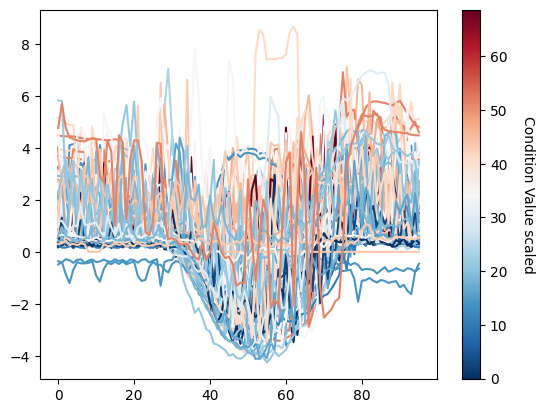

In [9]:
# create the data loader
dataLoader, scaler = tl.create_data_loader(df_train.values, batch_size=df_train.shape[0], shuffle=True) # I'm too lazy to wait, so I secretly load all the data once
data_plot = torch.tensor(scaler.transform(df_train.values[:,:]))
 # plot the real data, the y-axis is the value of the feature, the x-axis is the time, the color of profile indicates the total daily energy consumption
tl.plot_figure(data_plot , scaler, 2)

# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

*Start model training*

c:\Users\weijiexia\OneDrive - Delft University of Technology\Align4Energy\paper2\Github\Full-Convolutional-Time-Series-Flow\alg\models_fctflow_lin.py:52: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2432.)
  w_init = torch.qr(torch.randn(num_channels, num_channels))[0]


0 loss:  90.17635240020002


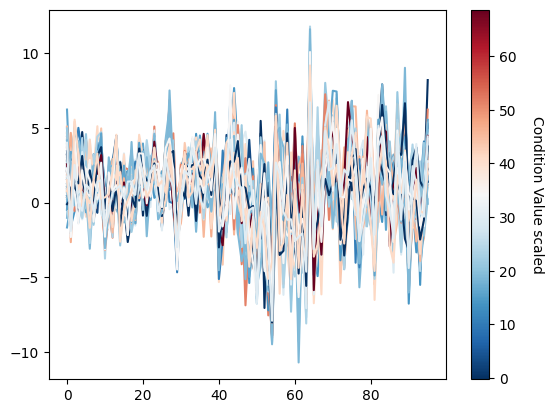

Energy distance:  0.4022237698595338 MSE.A:  0.1020462312519131
2000 loss:  -382.089931960414


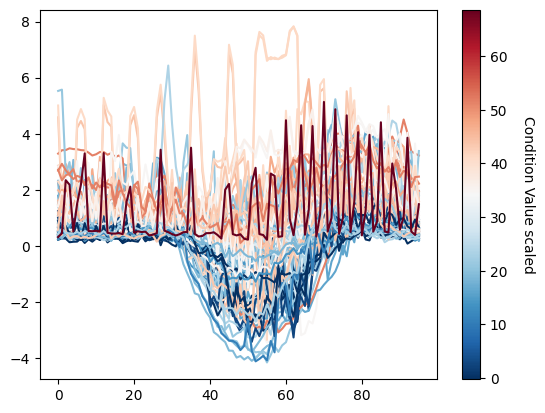

Energy distance:  0.1497569780099733 MSE.A:  0.019197769466551037
4000 loss:  -399.17279340004484


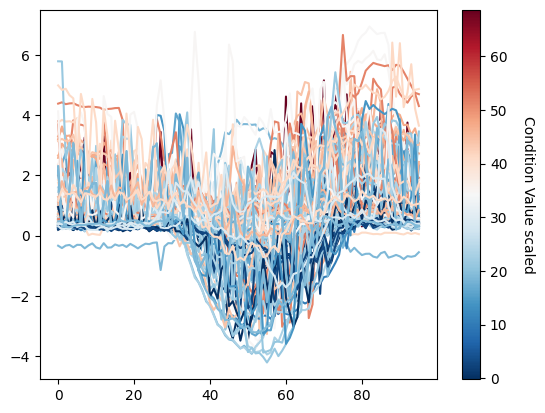

Energy distance:  0.11751719620793569 MSE.A:  0.013315392668265147
6000 loss:  -410.721889609697


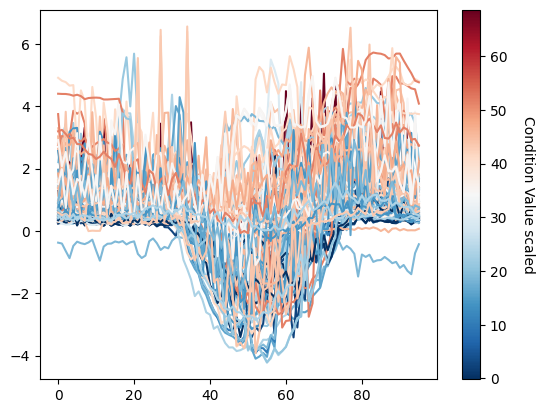

Energy distance:  0.0987253793264085 MSE.A:  0.01280274490131393
8000 loss:  -416.47773737936785


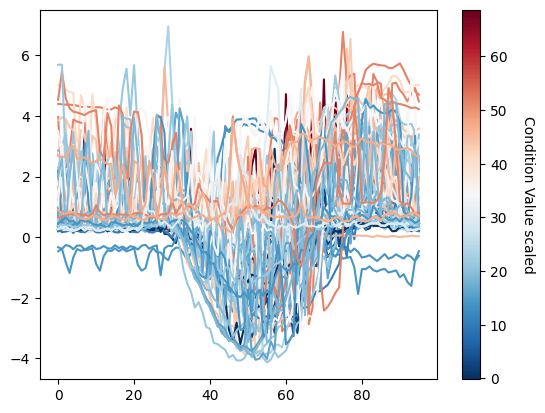

Energy distance:  0.06708376764563408 MSE.A:  0.005620605004874789
10000 loss:  -428.10864745967217


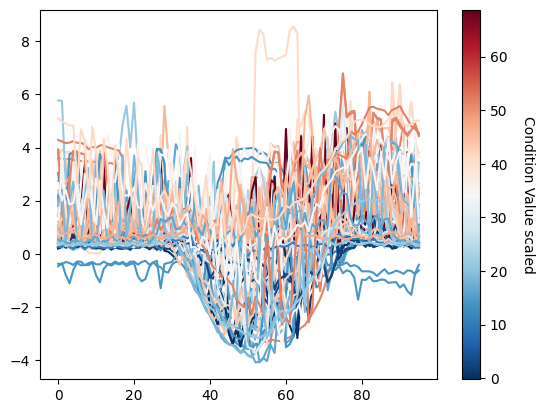

Energy distance:  0.05978515332028342 MSE.A:  0.005134872114806881
12000 loss:  -436.1553360751699


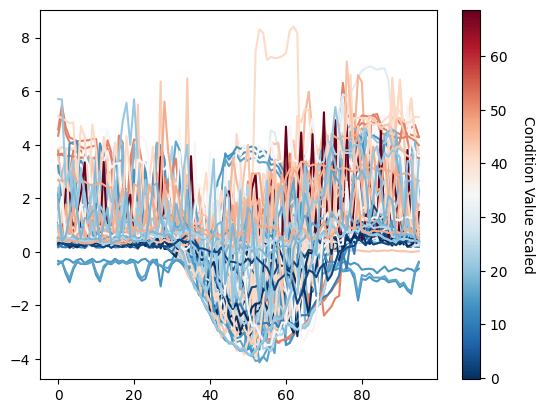

Energy distance:  0.02372671826222504 MSE.A:  0.0020477849482479116
14000 loss:  -444.4219992570243


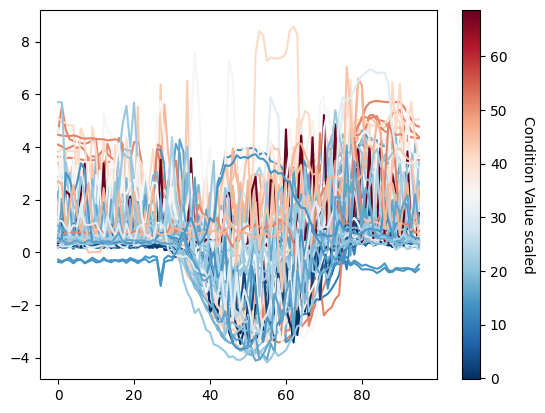

Energy distance:  0.032791776702012686 MSE.A:  0.0017508380664104574
16000 loss:  -450.5280886245123


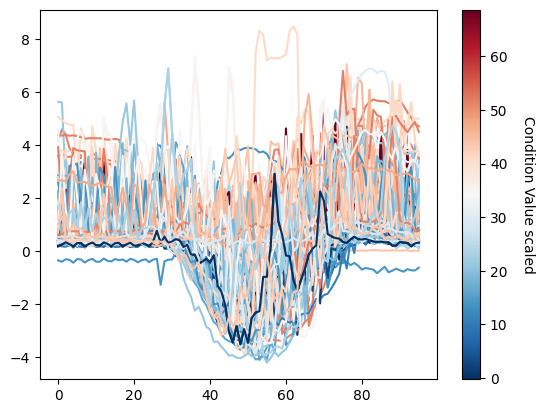

Energy distance:  0.02627472411293379 MSE.A:  0.0011637684363273591
18000 loss:  -461.00973986390443


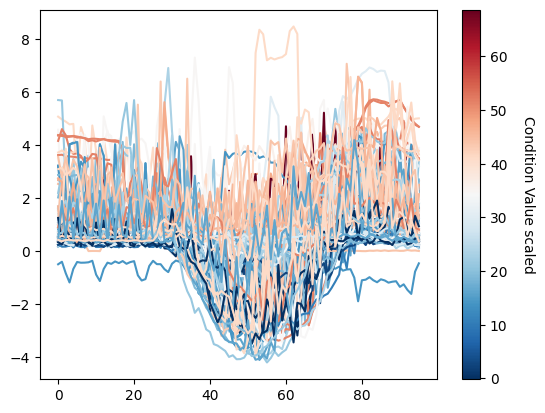

Energy distance:  0.02551316089142922 MSE.A:  0.0008371389257332022


In [10]:
# Train the model
while True:
        
    # hyperparameters
    num_blocks = 4 # a small number of blocks for this small example, better not exceed 20 blocks due to numerical instability
    net_type = 'fullconv'  
    sfactor = 0.3 # scaling factor, 0.1 to 1 is a good range, larger value will lead to numerical instability, samller value limits the range of the output
    hidden_dim = 96*2 # hidden dimension of the s and t networks
    lr = 0.001 # check tools.oy with we defined a learning rate decay function
    w_decay = 0 # weight decay of the optimizer

    # define the model
    num_channels = 96 # resolution of the time series 
    condition_dim = 2  # annual energy consumption and daily energy consumption
    model = fcpf.FCPflow(num_blocks, num_channels, net_type, sfactor, hidden_dim, condition_dim)

    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=w_decay)

    tl.train(model, dataLoader, optimizer, 20000, condition_dim, device, scaler, lr, test_set, pgap=2000)
    
    break # Opps, forgot to break the loop, in the expriment